In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import a_funciones as fn 
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn import tree ###para ajustar arboles de decisión
from sklearn.ensemble import RandomForestRegressor ##Ensamble con bagging
from sklearn.ensemble import GradientBoostingRegressor ###Ensamble boosting


In [2]:
#Se vuelve a llamar la base de datos para la seleccion de variables
data = pd.read_csv("https://raw.githubusercontent.com/jsebastianzm/HR_T1_Analitica/main/data/data_preprocesamiento.csv")

In [3]:
#Es necesario volver a asignar las variables como variables object ya que al crearse el dataframe y volver
# a leerse con la libreria pandas, las variables vuelven a cambiar de tipo.
columns_category = ['BusinessTravel', 'Department', 'Education', 'EducationField', 'EmployeeID', 'Gender', 
'JobLevel', 'JobRole', 'MaritalStatus', 'StockOptionLevel', 'EnvironmentSatisfaction', 'JobSatisfaction', 
'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating', 'Attrition']
data[columns_category] = data[columns_category].astype(object)
data.drop(['EmployeeID'], axis = 1, inplace = True)

In [4]:
#Se asignan las variables object a variables dummies
dummies_variables = ["BusinessTravel", "Department", "Education", "EducationField", "Gender", "JobLevel", 
                     "Gender", "JobLevel", "JobRole", "MaritalStatus", "StockOptionLevel", "EnvironmentSatisfaction", 
                     "JobSatisfaction", "WorkLifeBalance", "JobInvolvement", "PerformanceRating"]
data_dummies = pd.get_dummies(data, columns=dummies_variables)

In [5]:
#Se separan las bases de datos en la variable a predecir y las variables independientes
y = data_dummies["Attrition"]
x = data_dummies.loc[:, ~data_dummies.columns.isin(['Attrition'])]
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 75 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4410 non-null   int64  
 1   DistanceFromHome                   4410 non-null   float64
 2   MonthlyIncome                      4410 non-null   float64
 3   NumCompaniesWorked                 4410 non-null   int64  
 4   PercentSalaryHike                  4410 non-null   int64  
 5   TotalWorkingYears                  4410 non-null   int64  
 6   TrainingTimesLastYear              4410 non-null   int64  
 7   YearsAtCompany                     4410 non-null   int64  
 8   YearsSinceLastPromotion            4410 non-null   int64  
 9   YearsWithCurrManager               4410 non-null   int64  
 10  BusinessTravel_Non-Travel          4410 non-null   uint8  
 11  BusinessTravel_Travel_Frequently   4410 non-null   uint8

In [6]:
#Se aplica labelencoder a la variables Y
encoder = LabelEncoder()

# Ajustar y transformar las categorías
y = encoder.fit_transform(y)
y = pd.DataFrame(y, columns = ['Attrition'])
y.head()



,Attrition
0,0
1,1
2,0
3,0
4,0


In [7]:
scaler=StandardScaler()
scaler.fit(x)
X2=scaler.transform(x)
X=pd.DataFrame(X2,columns=x.columns)


In [10]:
m_lreg = LogisticRegression()
m_rtree=tree.DecisionTreeRegressor()
# m_rf= RandomForestRegressor()
# m_gbt=GradientBoostingRegressor()

# modelos=list([m_lreg,m_rtree, m_rf, m_gbt])
modelos=list([m_lreg,m_rtree])



In [11]:
#
var_names_models=fn.sel_variables(modelos,X,y,threshold="1.7*mean")
var_names_models.shape


(20,)

In [12]:
#Se aplica seleccion de variables con el metodo Lasso
var_names_lasso=fn.sel_variablesLasso(modelos,X,y,alpha=0.03,max_features=15)
var_names_lasso.shape

(10,)

In [13]:
X_mod=X[var_names_models] ### matriz con variables seleccionadas
print(X_mod.shape, X.shape)

(4410, 20) (4410, 75)


In [14]:
X_Lasso=X[var_names_lasso] ### matriz con variables seleccionadas
print(X_Lasso.shape, X.shape)

(4410, 10) (4410, 75)


In [15]:
#Medicion de los modelos para la clasificacion
F1_df=fn.medir_modelos(modelos,"f1",X,y,10) ## base con todas las variables 
F1_mod=fn.medir_modelos(modelos,"f1",X_mod,y,10) ### base con variables seleccionadas
F1_Lasso=fn.medir_modelos(modelos,"f1",X_Lasso,y,10) ### base con variables seleccionadas

## Toca agregar y completar el boxplot siguiente

<AxesSubplot: >

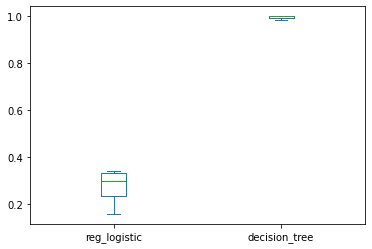

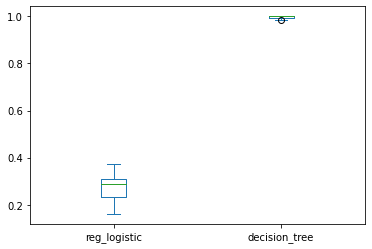

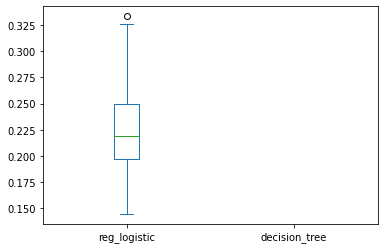

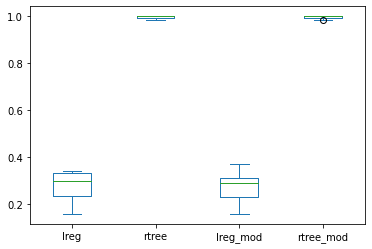

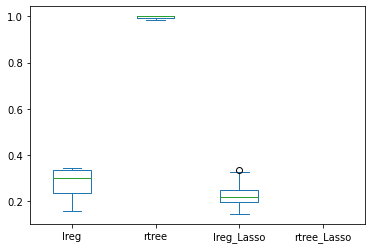

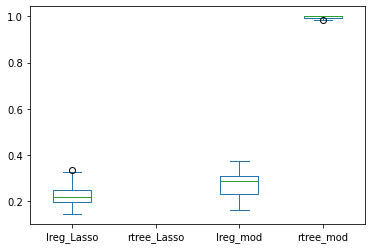

In [17]:
F1_score1 =pd.concat([F1_df,F1_mod],axis=1)
F1_score1.columns=['lreg', 'rtree',
    'lreg_mod', 'rtree_mod']

F1_score2 =pd.concat([F1_df,F1_Lasso],axis=1)
F1_score2.columns=['lreg', 'rtree',
    'lreg_Lasso', 'rtree_Lasso']

F1_score3 =pd.concat([F1_Lasso,F1_mod],axis=1)
F1_score3.columns=['lreg_Lasso', 'rtree_Lasso',
    'lreg_mod', 'rtree_mod']

F1_df.plot(kind='box') #### gráfico para modelos todas las varibles
F1_mod.plot(kind='box') ### gráfico para modelo variables seleccionadas
F1_Lasso.plot(kind='box') ### gráfico para modelos sel y todas las variables
F1_score1.plot(kind='box')
F1_score2.plot(kind='box')
F1_score3.plot(kind='box')

In [18]:
F1_score1.mean()####################################################

lreg         0.283155
rtree        0.996404
lreg_mod     0.274741
rtree_mod    0.996283
dtype: float64

In [19]:
F1_score2.mean()#####################################################

lreg           0.283155
rtree          0.996404
lreg_Lasso     0.230656
rtree_Lasso         NaN
dtype: float64

In [20]:
F1_score3.mean() #####################################################

lreg_Lasso     0.230656
rtree_Lasso         NaN
lreg_mod       0.274741
rtree_mod      0.996283
dtype: float64

In [ ]:
# # Separación en conjuntos de entrenamiento y validación con 80% de muestras para entrenamiento
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [ ]:
# #Estandarización de variables númericas
# numeric_columns = data_dummies.loc[:, data_dummies.columns.isin(['Age', 'DistanceFromHome', 'EmployeeID', 
#                                 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears',
#                                 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager'])]
# pipeline=ColumnTransformer([( "std_numericas",StandardScaler() , numeric_columns)], remainder='passthrough')

# x_train = pipeline.fit_transform(x_train)
# x_test = pipeline.transform(x_test)